In [84]:
import csv
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import Preprocessing as pp
from scipy.io import loadmat
from sklearn import metrics

In [2]:
temp_data_folder = '../Data/Temp_Data/'

## Import Data and small visualisation

In [3]:
raw_validation_nsoll = loadmat('../Data/Raw_Data/n_soll.mat')['n_soll'][0::1000]
raw_validation_time_nsoll = loadmat('../Data/Raw_Data/t_nsoll.mat')['t_2A_ela'].T[0::1000]

raw_validation_elrms = loadmat('../data/Raw_Data/P_el_rms.mat')['P_elrms'][0]
raw_validation_t_elrms = loadmat('../data/Raw_Data/t_el_rms.mat')['t_el_mean'][0]

raw_validation_th = loadmat('../data/Raw_Data/P_th.mat')['P_th'][0][0::10]
raw_validation_t_th = loadmat('../data/Raw_Data/t_th.mat')['t_1B_th'][0][0::10]

In [4]:
df_validation = pd.DataFrame()
df_validation['spinning'] = pp.downsampleData(raw_validation_time_nsoll, raw_validation_nsoll)[:,1]
df_validation['time'] = pp.downsampleData(raw_validation_time_nsoll, raw_validation_time_nsoll)[:,1]
df_validation['electric'] = pp.downsampleData(raw_validation_t_elrms, raw_validation_elrms)[:,1]
df_validation['thermal'] = pp.downsampleData(raw_validation_t_th, raw_validation_th)[:,1]

In [5]:
df_validation.to_csv(temp_data_folder + "experiment_1B.csv",
                    index = False, sep = "|", encoding='utf-8')

In [67]:
def voltageForAllTimeSteps(time_splits, voltage_splits):
    time = np.array(range(int(time_splits[-1])))
    voltages = np.array(range(int(time_splits[-1])))
    for i in range(len(time_splits)-1):
        lower = int(time_splits[i])
        upper = int(time_splits[i+1])
        v = voltage_splits[i]
        voltages[lower:upper] = v
    return time, voltages

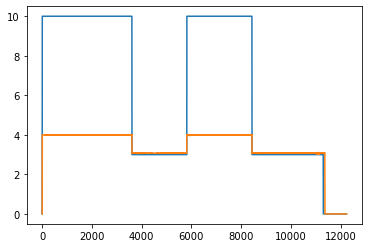

In [102]:
time_splits = [0, 1, 3605, 3606, 5811, 5812, 8429, 8430, 11294, 11295, len(df_validation['time'])]
voltage_splits = [0, 10, 10, 3, 3, 10, 10, 3, 3, 0, 0]
df_validation['time'], df_validation['voltage'] = voltageForAllTimeSteps(time_splits, voltage_splits)

plt.plot(df_validation['time'], df_validation['voltage'])
plt.plot(df_validation['time'], df_validation['spinning']/1000)
plt.show()

In [75]:
df_input = pp.openCSVFile('input_drehzahl.csv', temp_data_folder)
df_input_drehzahl = pd.DataFrame()
dummy = []
df_input_drehzahl['nsoll_time'], df_input_drehzahl['nsoll_input_voltage'] = voltageForAllTimeSteps(np.array(df_input['nsoll_time'][:-1]), np.array(df_input['nsoll_input_voltage'][:-1]))
dummy, df_input_drehzahl['nsoll_measured'] = voltageForAllTimeSteps(np.array(df_input['nsoll_time'][:-1]), np.array(df_input['nsoll_measured'][:-1]))

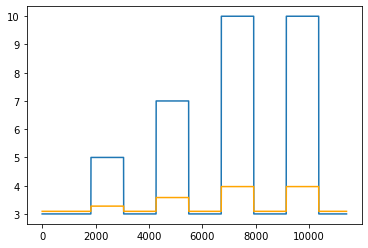

In [76]:
plt.plot(df_input_drehzahl['nsoll_time'], df_input_drehzahl['nsoll_input_voltage'])
plt.plot(df_input_drehzahl['nsoll_time'], df_input_drehzahl['nsoll_measured']/1000, 'orange')
plt.show()

## Predict spinning amount based on input

In [77]:
from sklearn import linear_model

In [78]:
reg_spin = linear_model.Ridge()
reg_spin.fit(df_input_drehzahl[['nsoll_input_voltage']], df_input_drehzahl['nsoll_measured'])

Ridge()

In [81]:
df_validation['spin_predict'] = reg_spin.predict(df_validation[['voltage']])

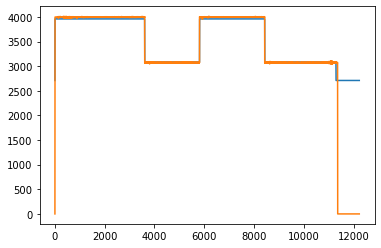

In [82]:
plt.plot(df_validation['time'], df_validation['spin_predict'])
plt.plot(df_validation['time'], df_validation['spinning'])

In [88]:
def measureDifference(data, value_header, approx_header):
    R_SQUARED = True
    RSME = True
    
    data = data[data[approx_header].notnull()]
    values = data[value_header]
    approx = data[approx_header]
    
    if RSME:
        rms = metrics.mean_squared_error(values, approx, squared=False)
        print('The RMSE is %5.3f' %rms)
    if R_SQUARED:
        r2 = metrics.r2_score(values, approx)
        print('The R2-score is %5.3f' %r2)

In [118]:
measureDifference(df_validation[:11290], 'spinning', 'spin_predict')

The RMSE is 39.263
The R2-score is 0.993


## Predict voltage amount based on input

In [94]:
df_input_el_raw = pp.openCSVFile('el_output_raw.csv', temp_data_folder)
df_input_el_approx = pp.openCSVFile('el_output_approx.csv', temp_data_folder)

In [145]:
reg_volt = linear_model.Ridge()
reg_volt.fit(np.array(df_input_el_approx['el_time_approx']).reshape(-1,1), np.array(df_input_el_approx['el_power_approx']))

Ridge()

In [147]:
df_validation['el_predict'] = reg_volt.predict(df_validation[['time']])

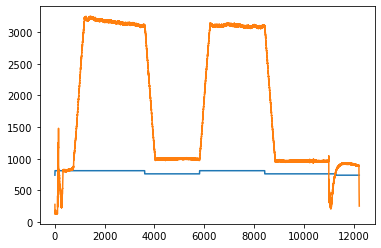

In [148]:
plt.plot(df_validation['time'], df_validation['volt_predict'])
plt.plot(df_validation['time'], df_validation['electric'])